In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import scipy.io.wavfile as wf
from sklearn.preprocessing import MultiLabelBinarizer
import IPython.display as ipd
import math
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
base_path = Path('../input')
data_path = base_path
train_noisy_path = data_path/'train_noisy'
train_curated_path = data_path/'train_curated'
test_path = data_path/'test'

### Load csv files

In [3]:
train_noisy_df = pd.read_csv(data_path/'train_noisy.csv')
train_curated_df = pd.read_csv(data_path/'train_curated.csv')
train_noisy_df['source'] = 'noisy'
train_curated_df['source'] = 'curated'
train_df = pd.concat([train_noisy_df, train_curated_df])
train_df['full_path'] = np.where(train_df.source=='noisy', str(train_noisy_path)+ '/', str(train_curated_path)+ '/')  + train_df.fname

### Binarize labels

In [4]:
mlb = MultiLabelBinarizer()
bin_labels = mlb.fit_transform(train_df.labels.str.split(',').values)
train_df['label_count'] = bin_labels.sum(1)

### Generate test set dataframe

In [5]:
test_files = []
for ps, ds, fs in os.walk(test_path):
    for f in fs:
        test_files.append(ps+'/'+f)
        
test_df = pd.DataFrame({'full_path':test_files})

test_df['source'] = 'test'

### Concatenate train datasets

In [6]:
train_df = pd.concat([train_df, pd.DataFrame(data=bin_labels, index= train_df.index, columns=mlb.classes_)], axis=1)

### Compute statistics

In [7]:
stats_cols = ['sr','length_secs','mean','std','abs_mean','abs_std']

def get_sig_stats(fname):
    sr, sig = wf.read(fname)
    return sr, len(sig)/sr, sig.mean(), sig.std(), abs(sig).mean(), abs(sig).std()

def add_stats_cols(df, n_jobs=8):
    batch_size = math.ceil(len(df)/n_jobs)

    dfs = [df.iloc[i*batch_size:min(len(df), (i+1)*batch_size)] for i in range(n_jobs)]
    
    def apply_stats(d):
        return d.full_path.apply(get_sig_stats) 
    
    stats = pd.concat(Parallel(n_jobs=n_jobs)(delayed(apply_stats)(d) for d in dfs))

    
    for i, stat in enumerate(stats_cols):
        df[stat] = stats.apply(lambda x: x[i])

In [8]:
%%time
add_stats_cols(train_df)

CPU times: user 328 ms, sys: 176 ms, total: 504 ms
Wall time: 1min 58s


In [9]:
%%time
add_stats_cols(test_df)

CPU times: user 52 ms, sys: 8 ms, total: 60 ms
Wall time: 3.74 s


### Merge train and test stats dataframes

In [10]:
stats_df = pd.concat([test_df, train_df[test_df.columns]])

### Compare statistics curated, noisy and test sets

In [11]:
stats = [stat for stat in stats_cols if stat != 'sr']

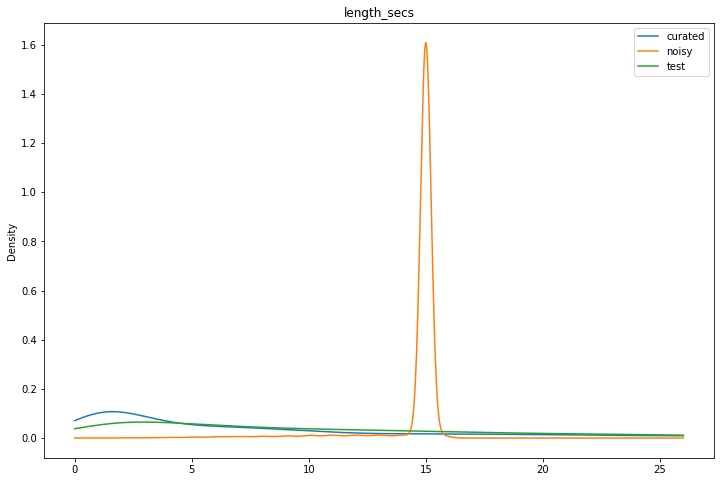

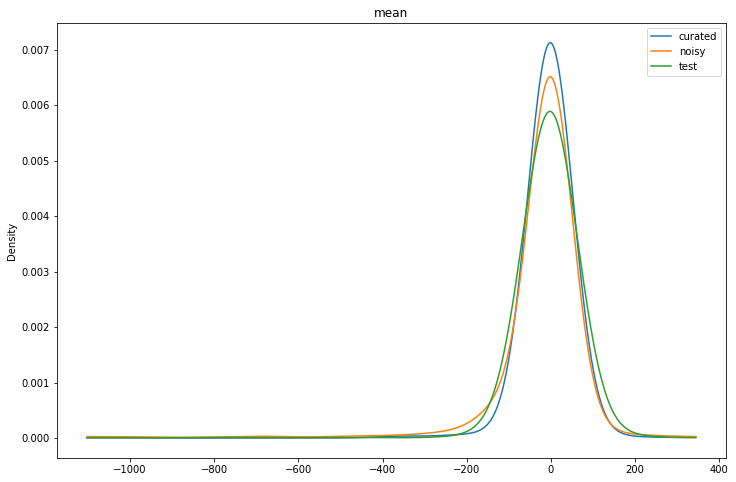

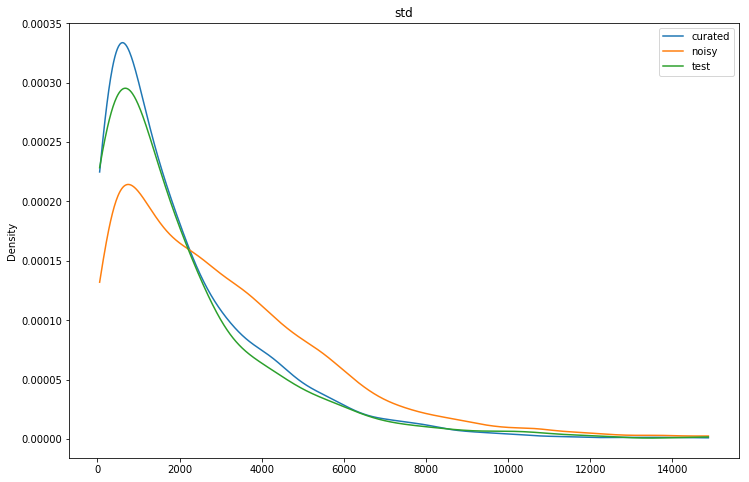

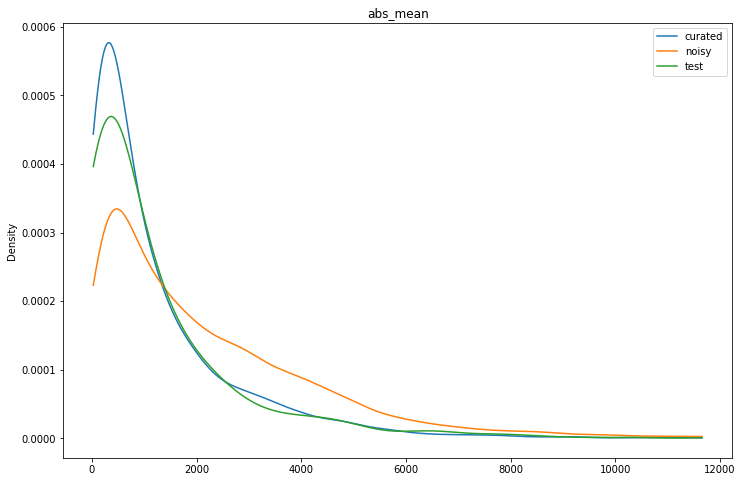

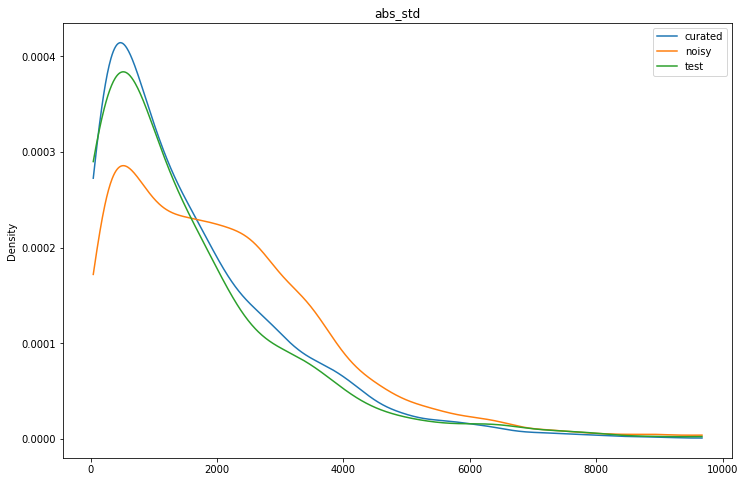

In [12]:
for stat in stats:
    lower = round(stats_df[stat].quantile(0.01))
    upper = round(stats_df[stat].quantile(0.99))

    ind = np.linspace(lower, upper, 1000)

    plt.figure(figsize=(12,8))
    ax = stats_df.groupby('source')[stat].plot.kde(ind=ind)
    ax[0].set_title(stat)
    ax[0].legend()

In [13]:
def plot_label_stats(df, stat):
    
    label_count   = 8
    class_count   = len(mlb.classes_)
    columns_count = 2
    fig_count     = math.ceil(class_count/label_count)
    row_count     = math.ceil(fig_count/columns_count)
    fig_width     = 18
    
    fig, axes = plt.subplots(row_count, columns_count, figsize=(fig_width,(fig_width/columns_count)*row_count))
    
    lower = round(df[stat].quantile(0.01))
    upper = round(df[stat].quantile(0.99))

    ind = np.linspace(lower, upper, 1000)

    for i in range(fig_count):
        classes = mlb.classes_[(i)*label_count:min((i+1)*label_count,len(mlb.classes_))]
        ax = axes[i//columns_count][i%columns_count]                                
        for c in classes:
            df[(df[c] == 1)][stat].plot.kde(ind = ind, ax=ax)     
        ax.legend(classes)
        ax.set_title(stat)
    plt.plot()

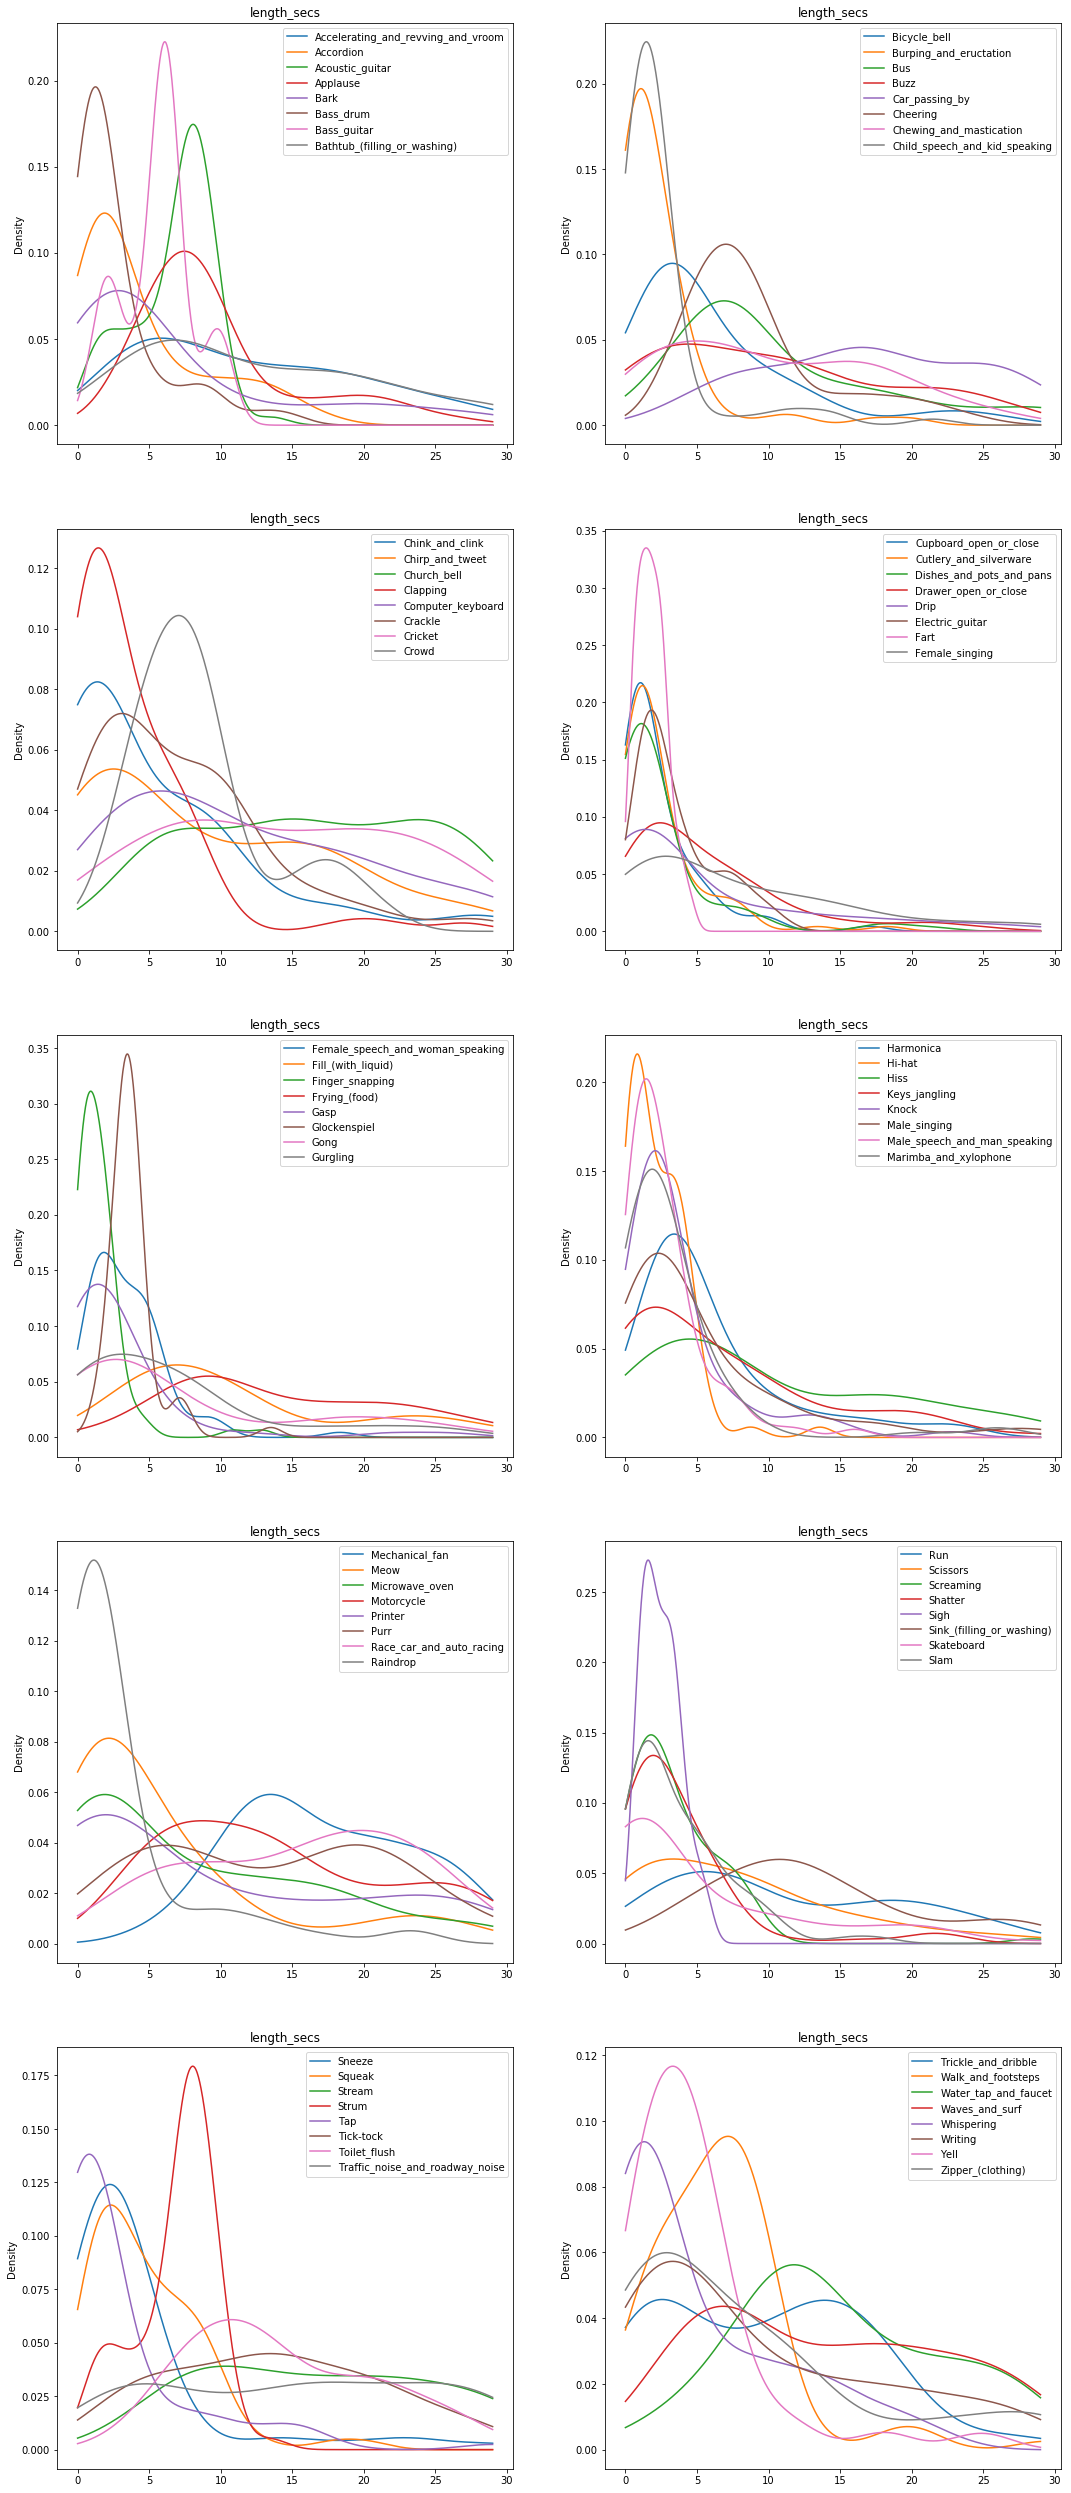

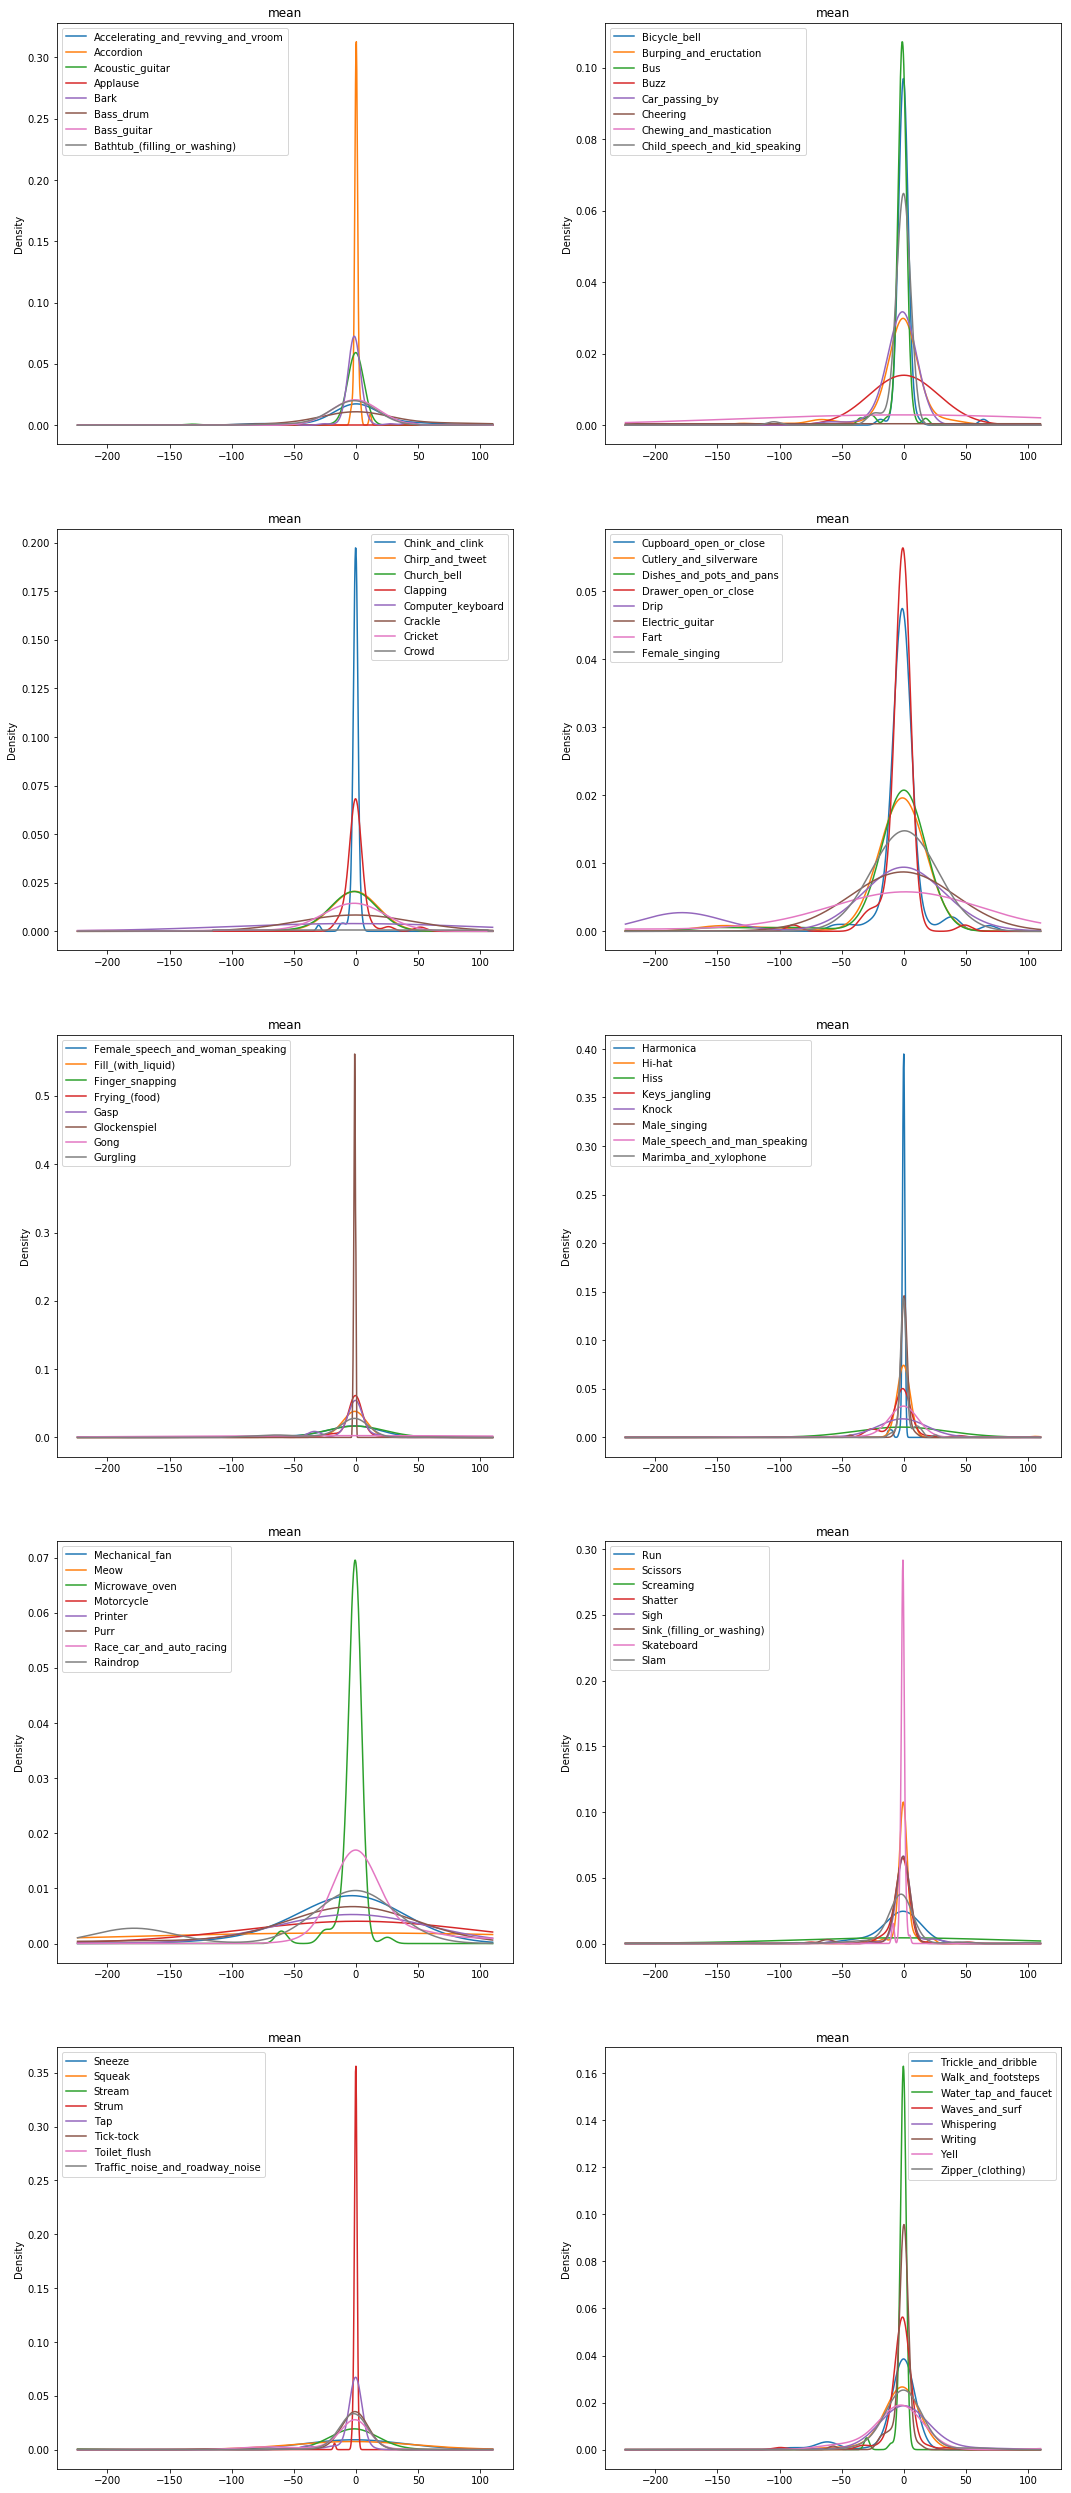

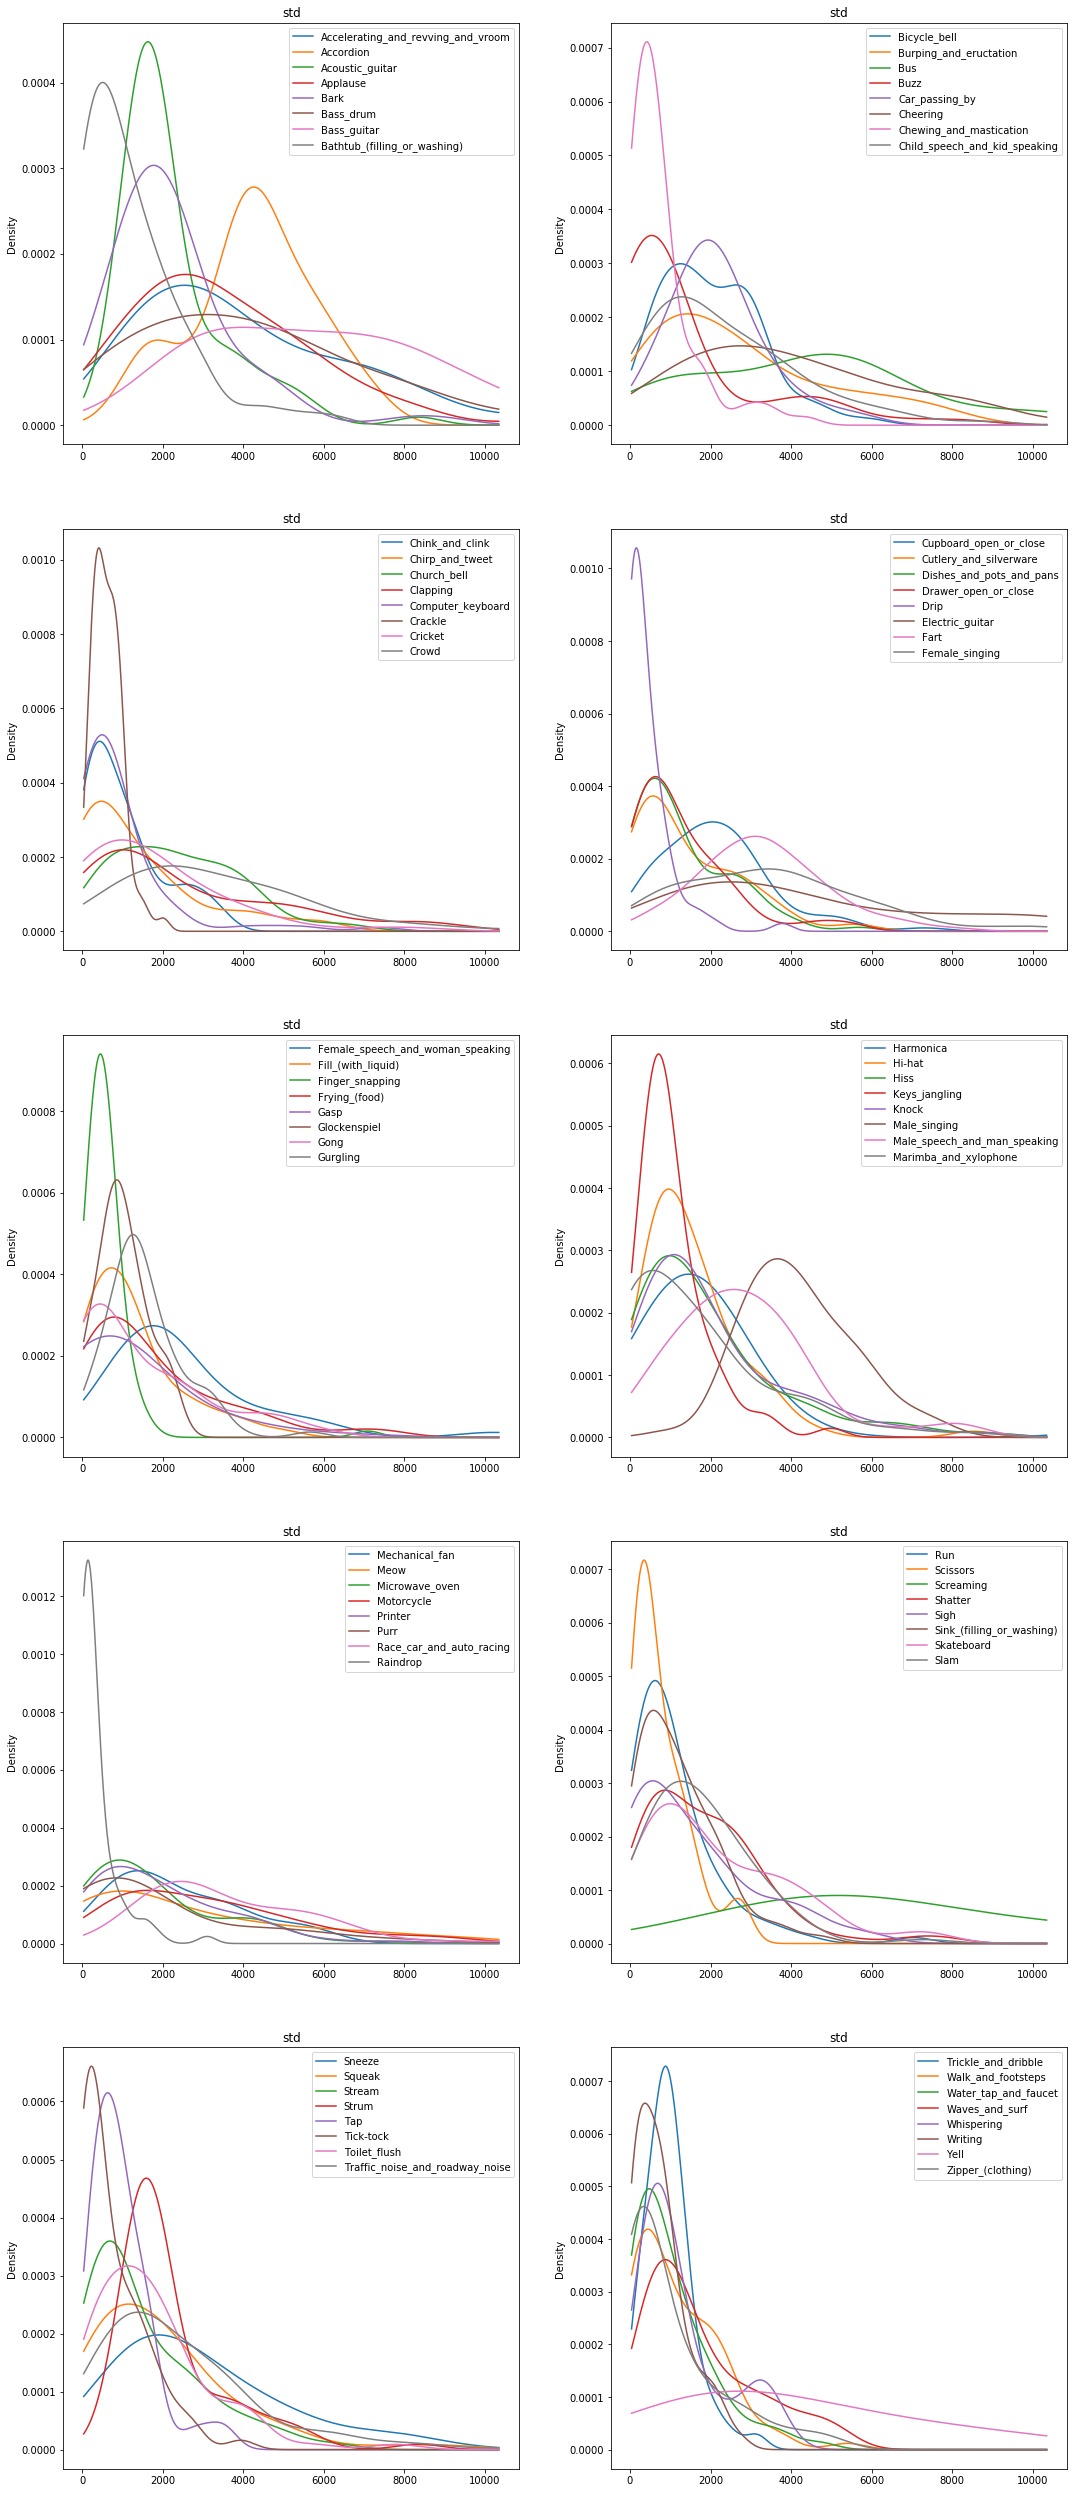

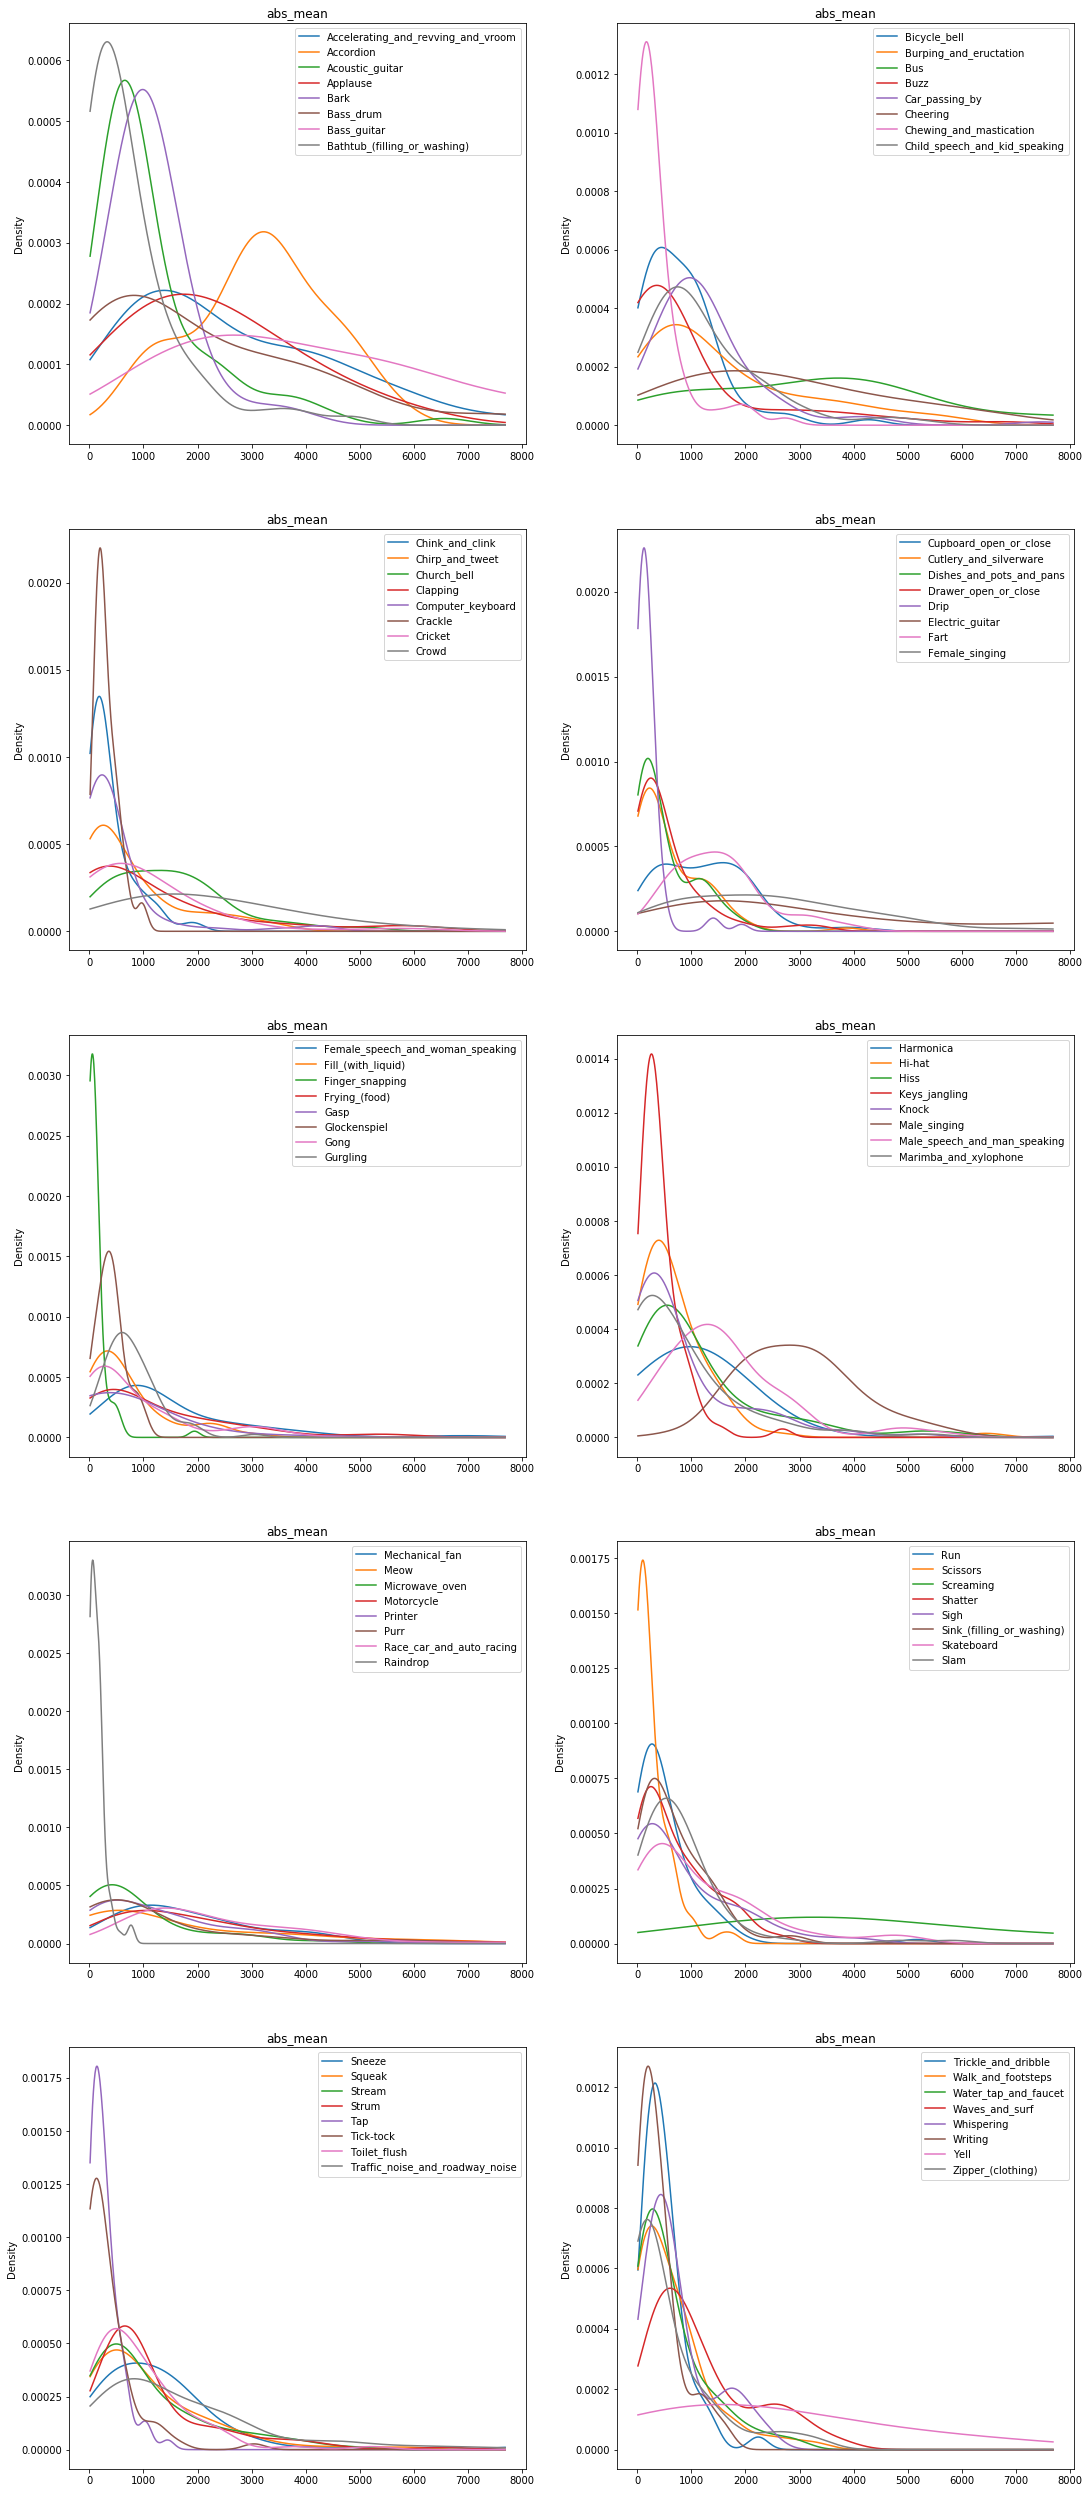

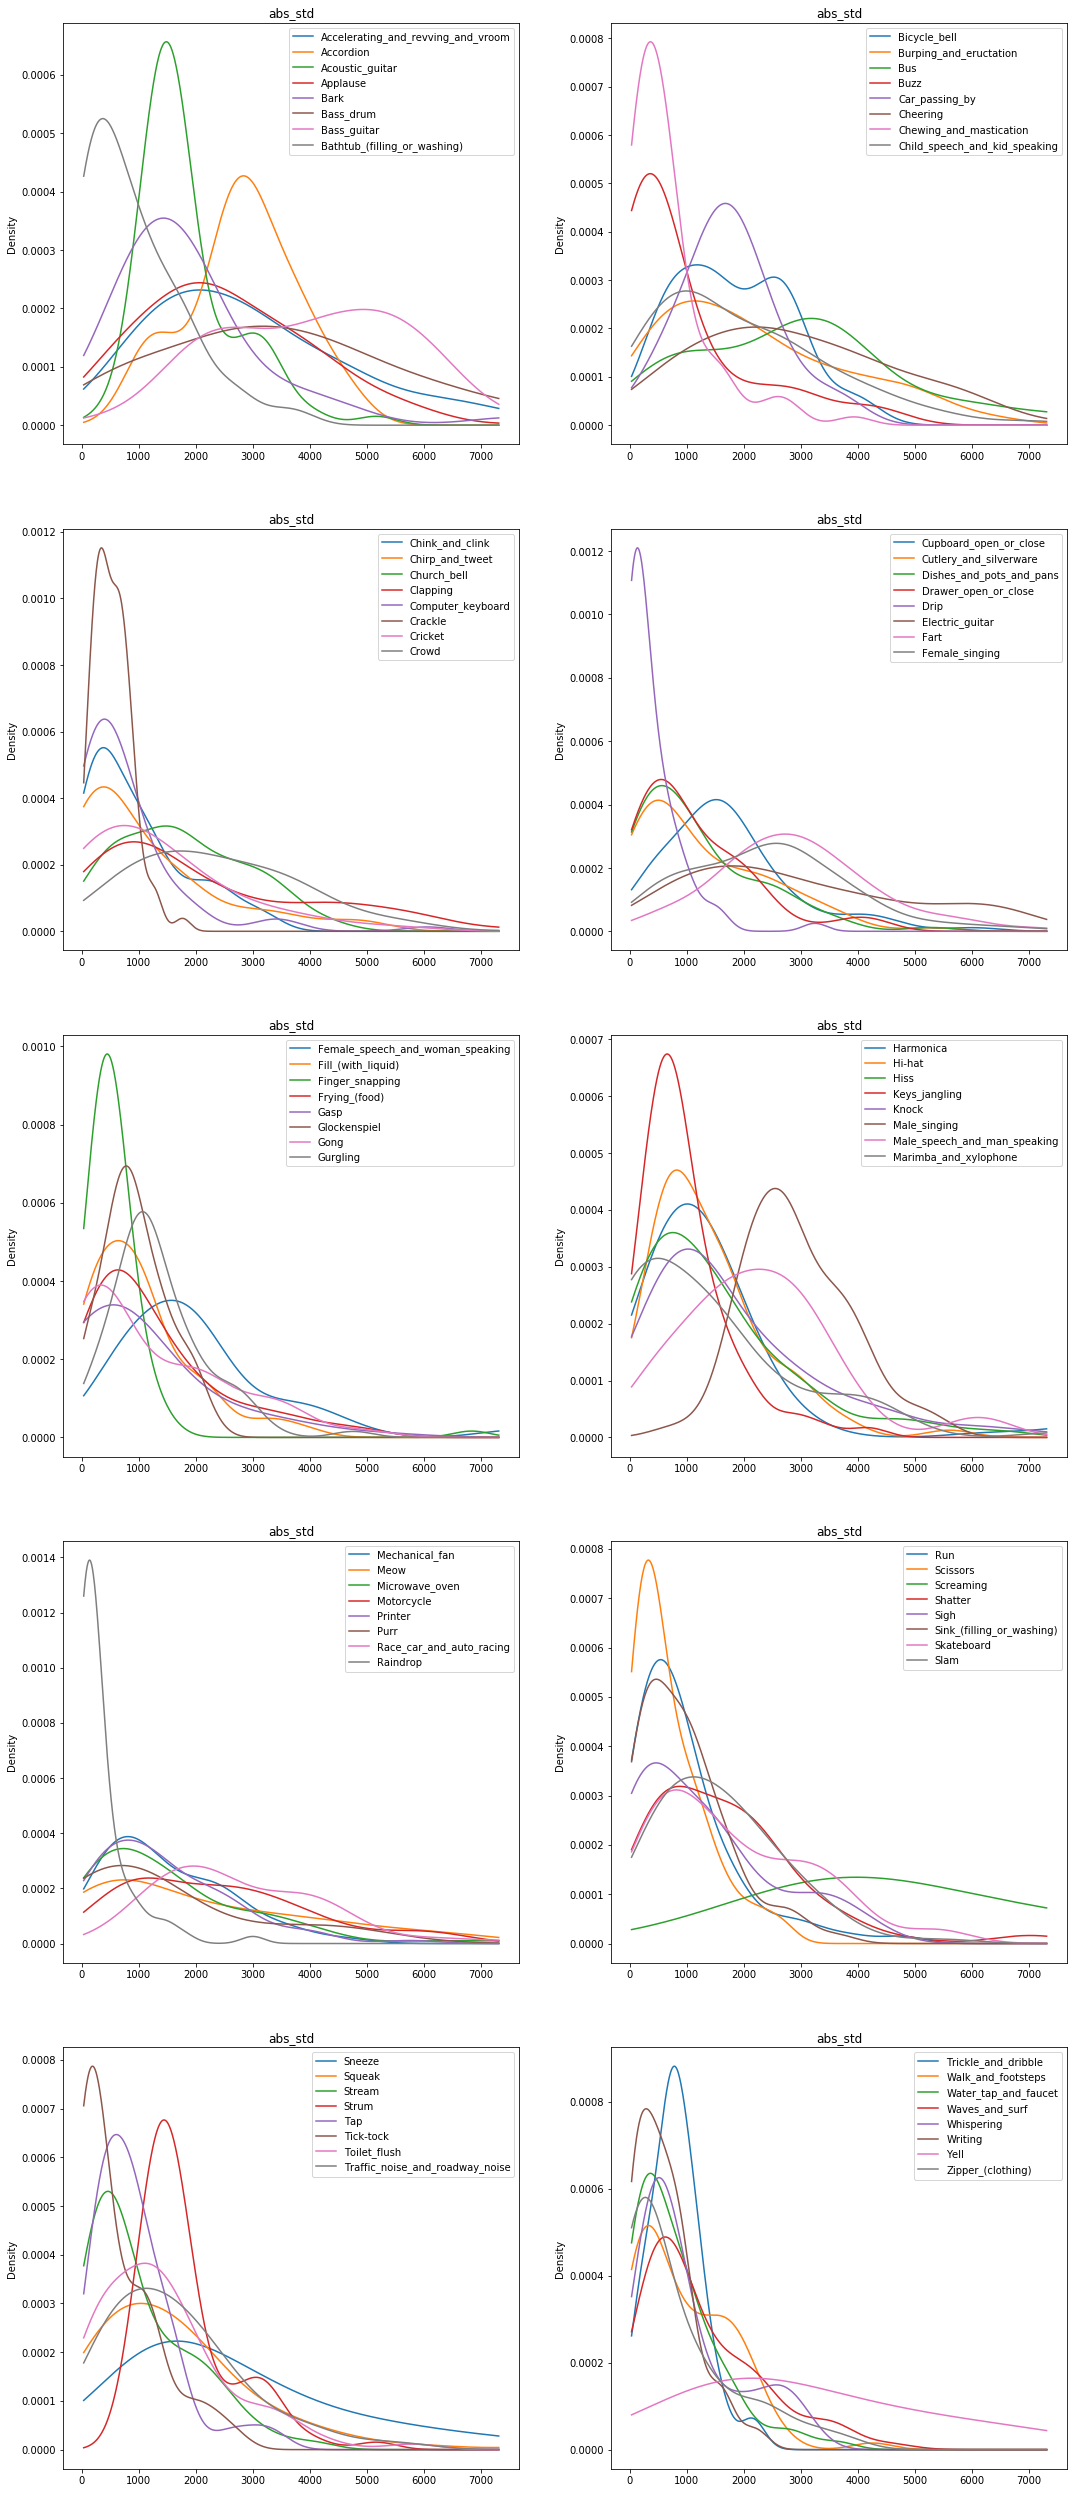

In [14]:
for stat in stats:
    plot_label_stats(train_df[train_df.source=='curated'], stat)

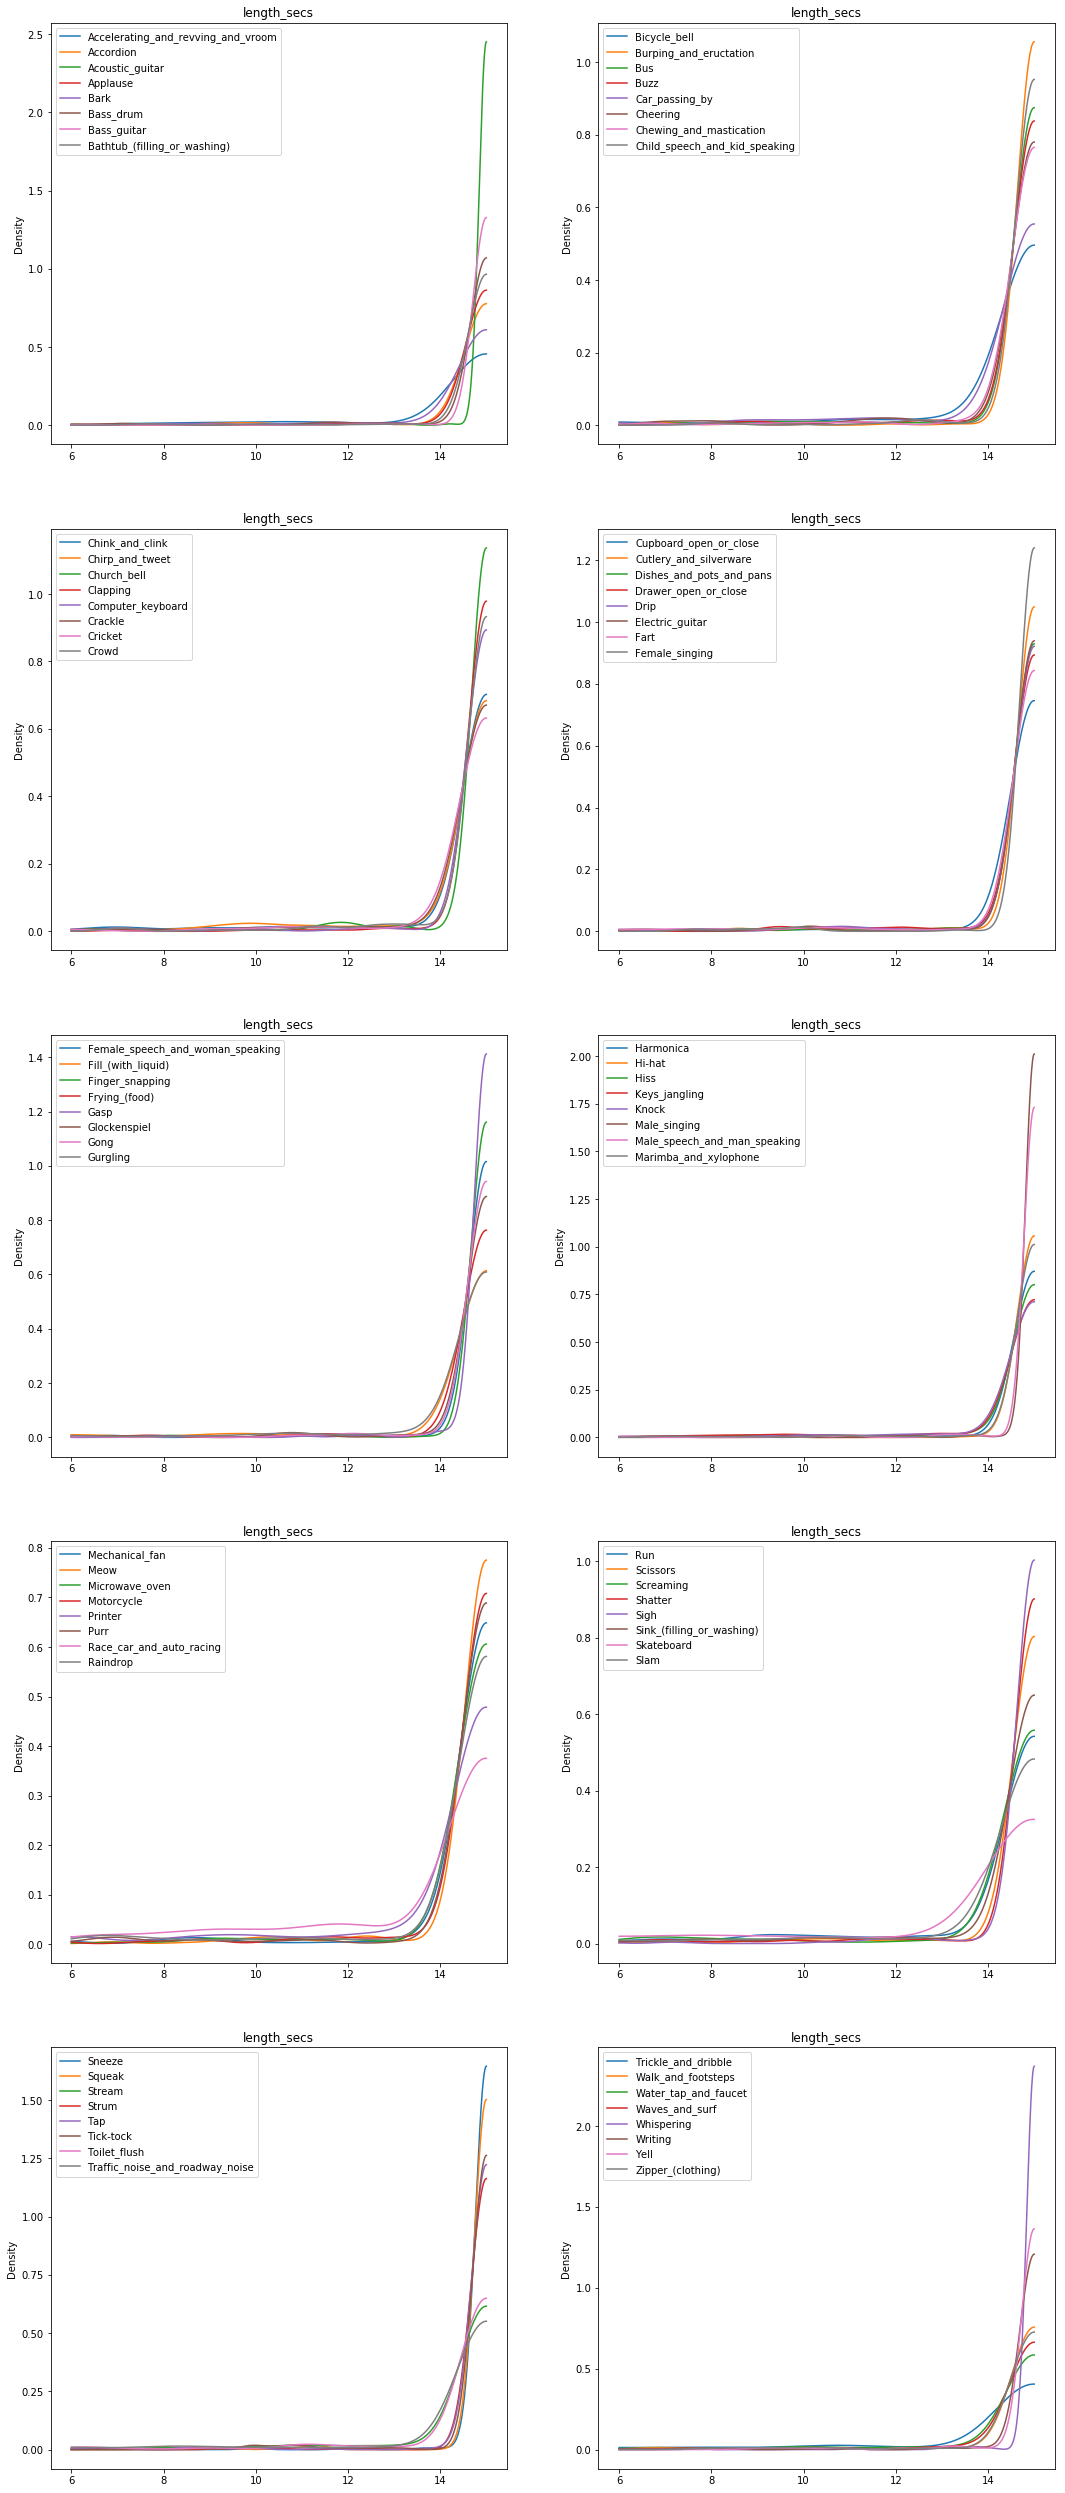

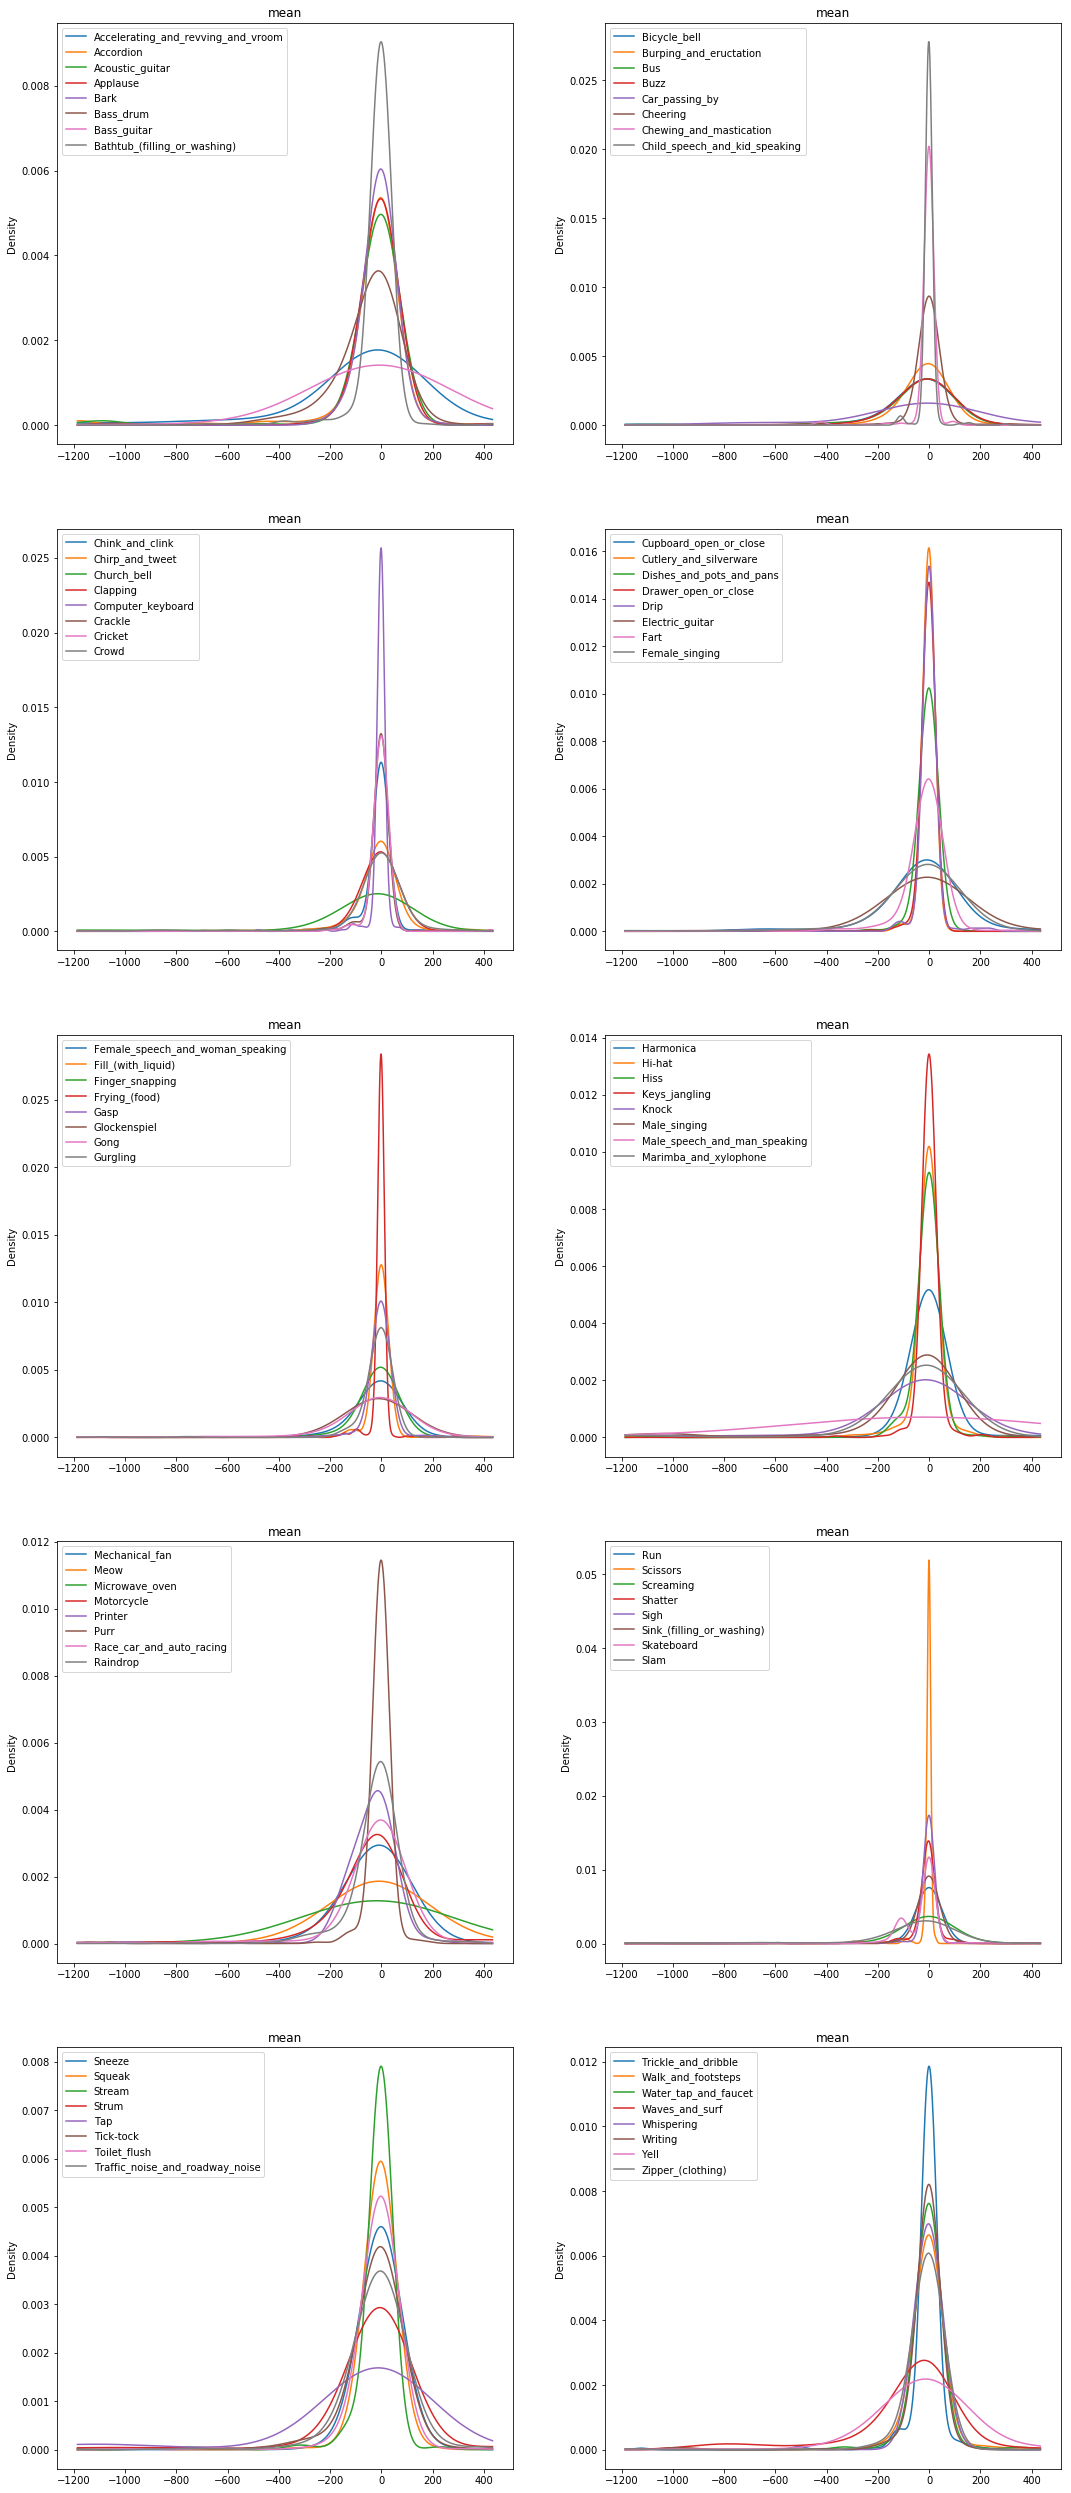

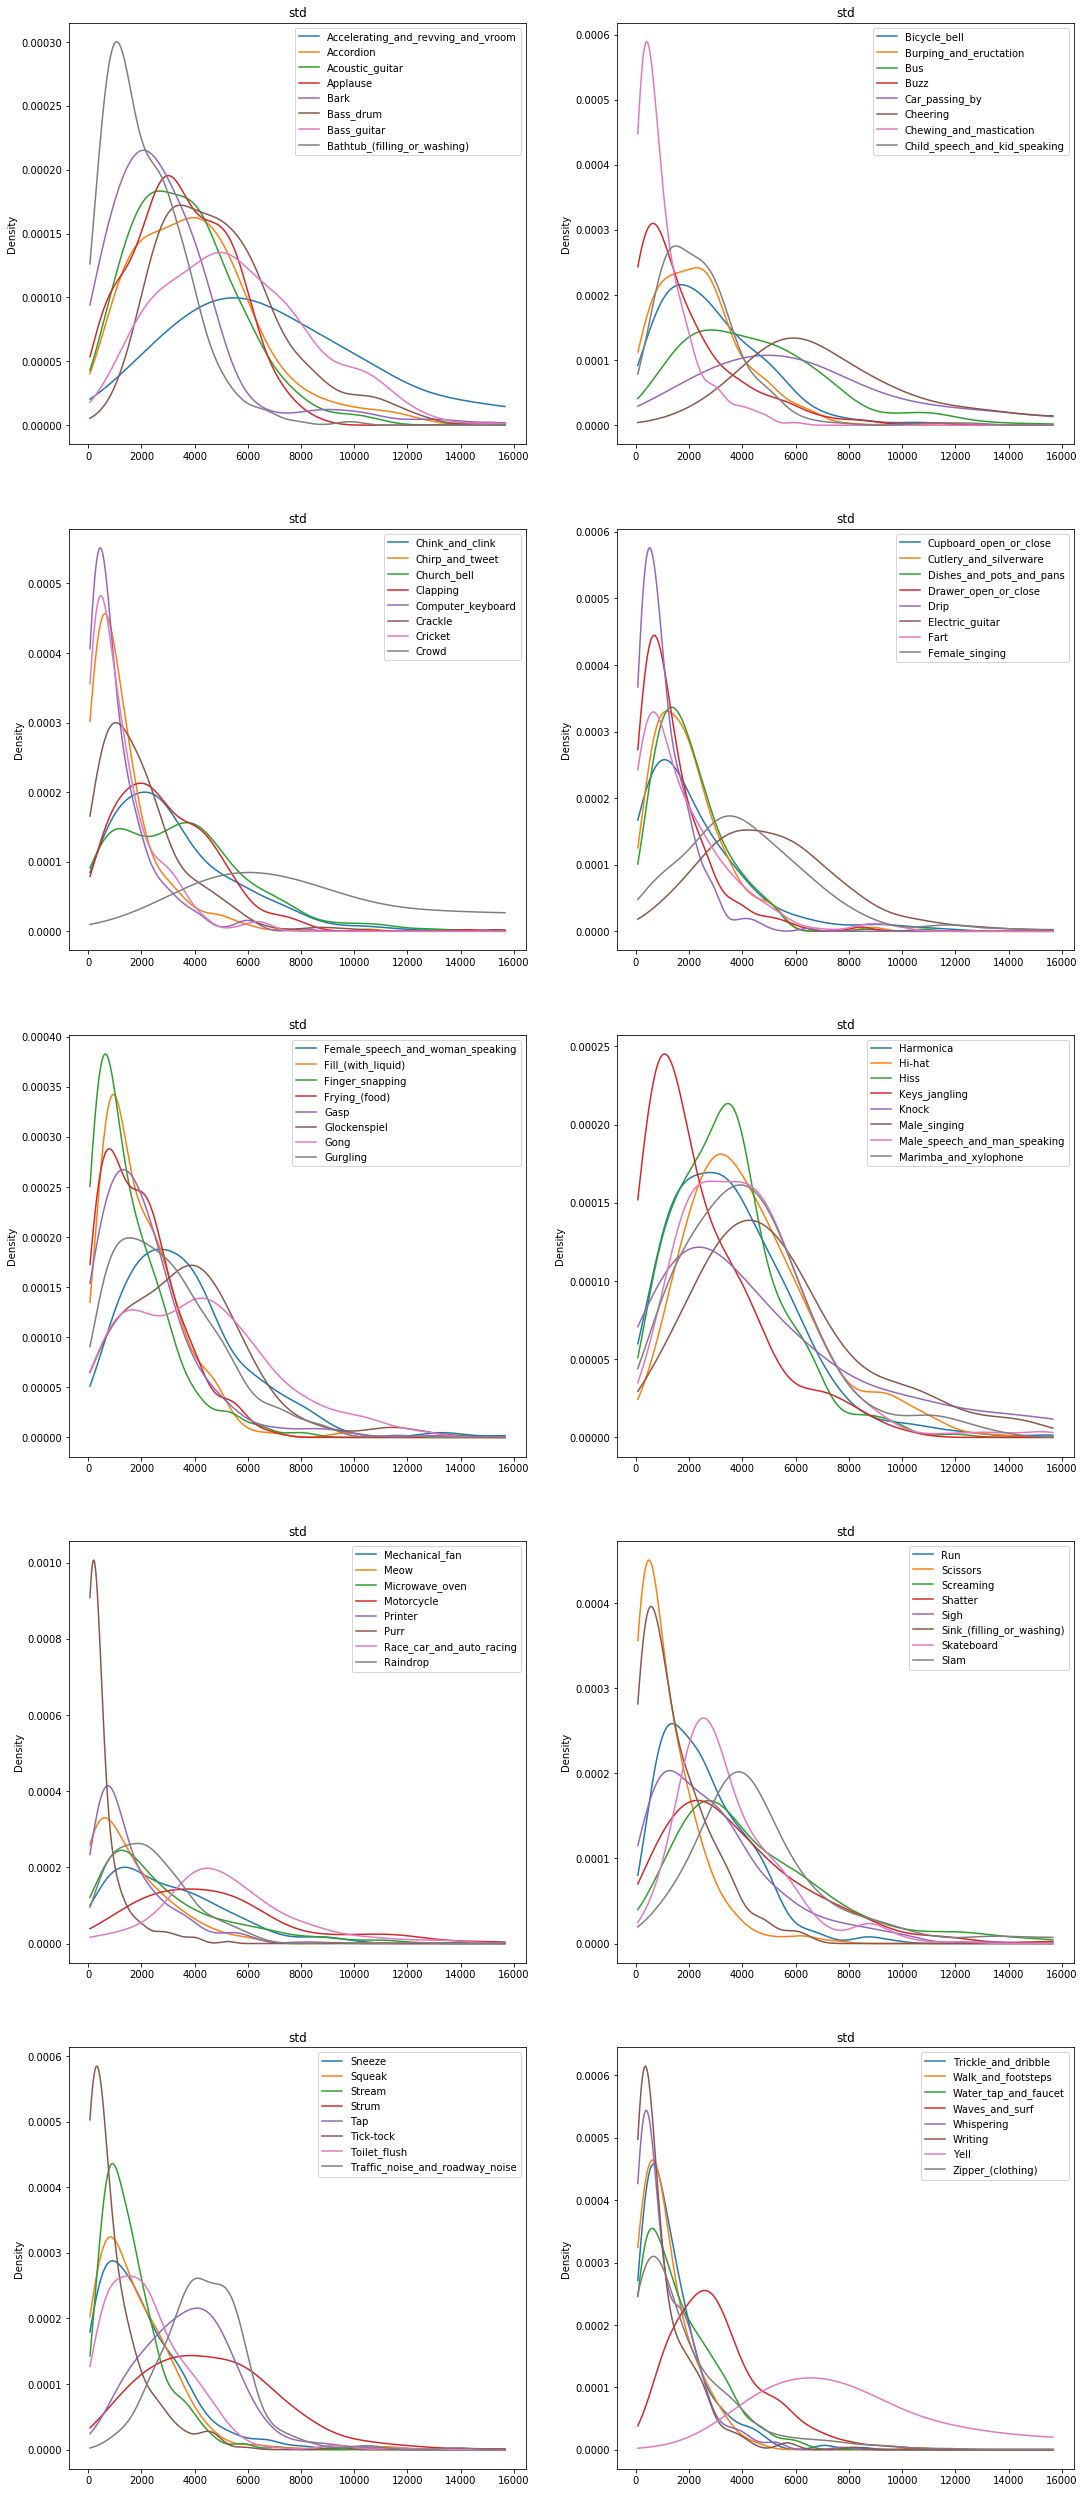

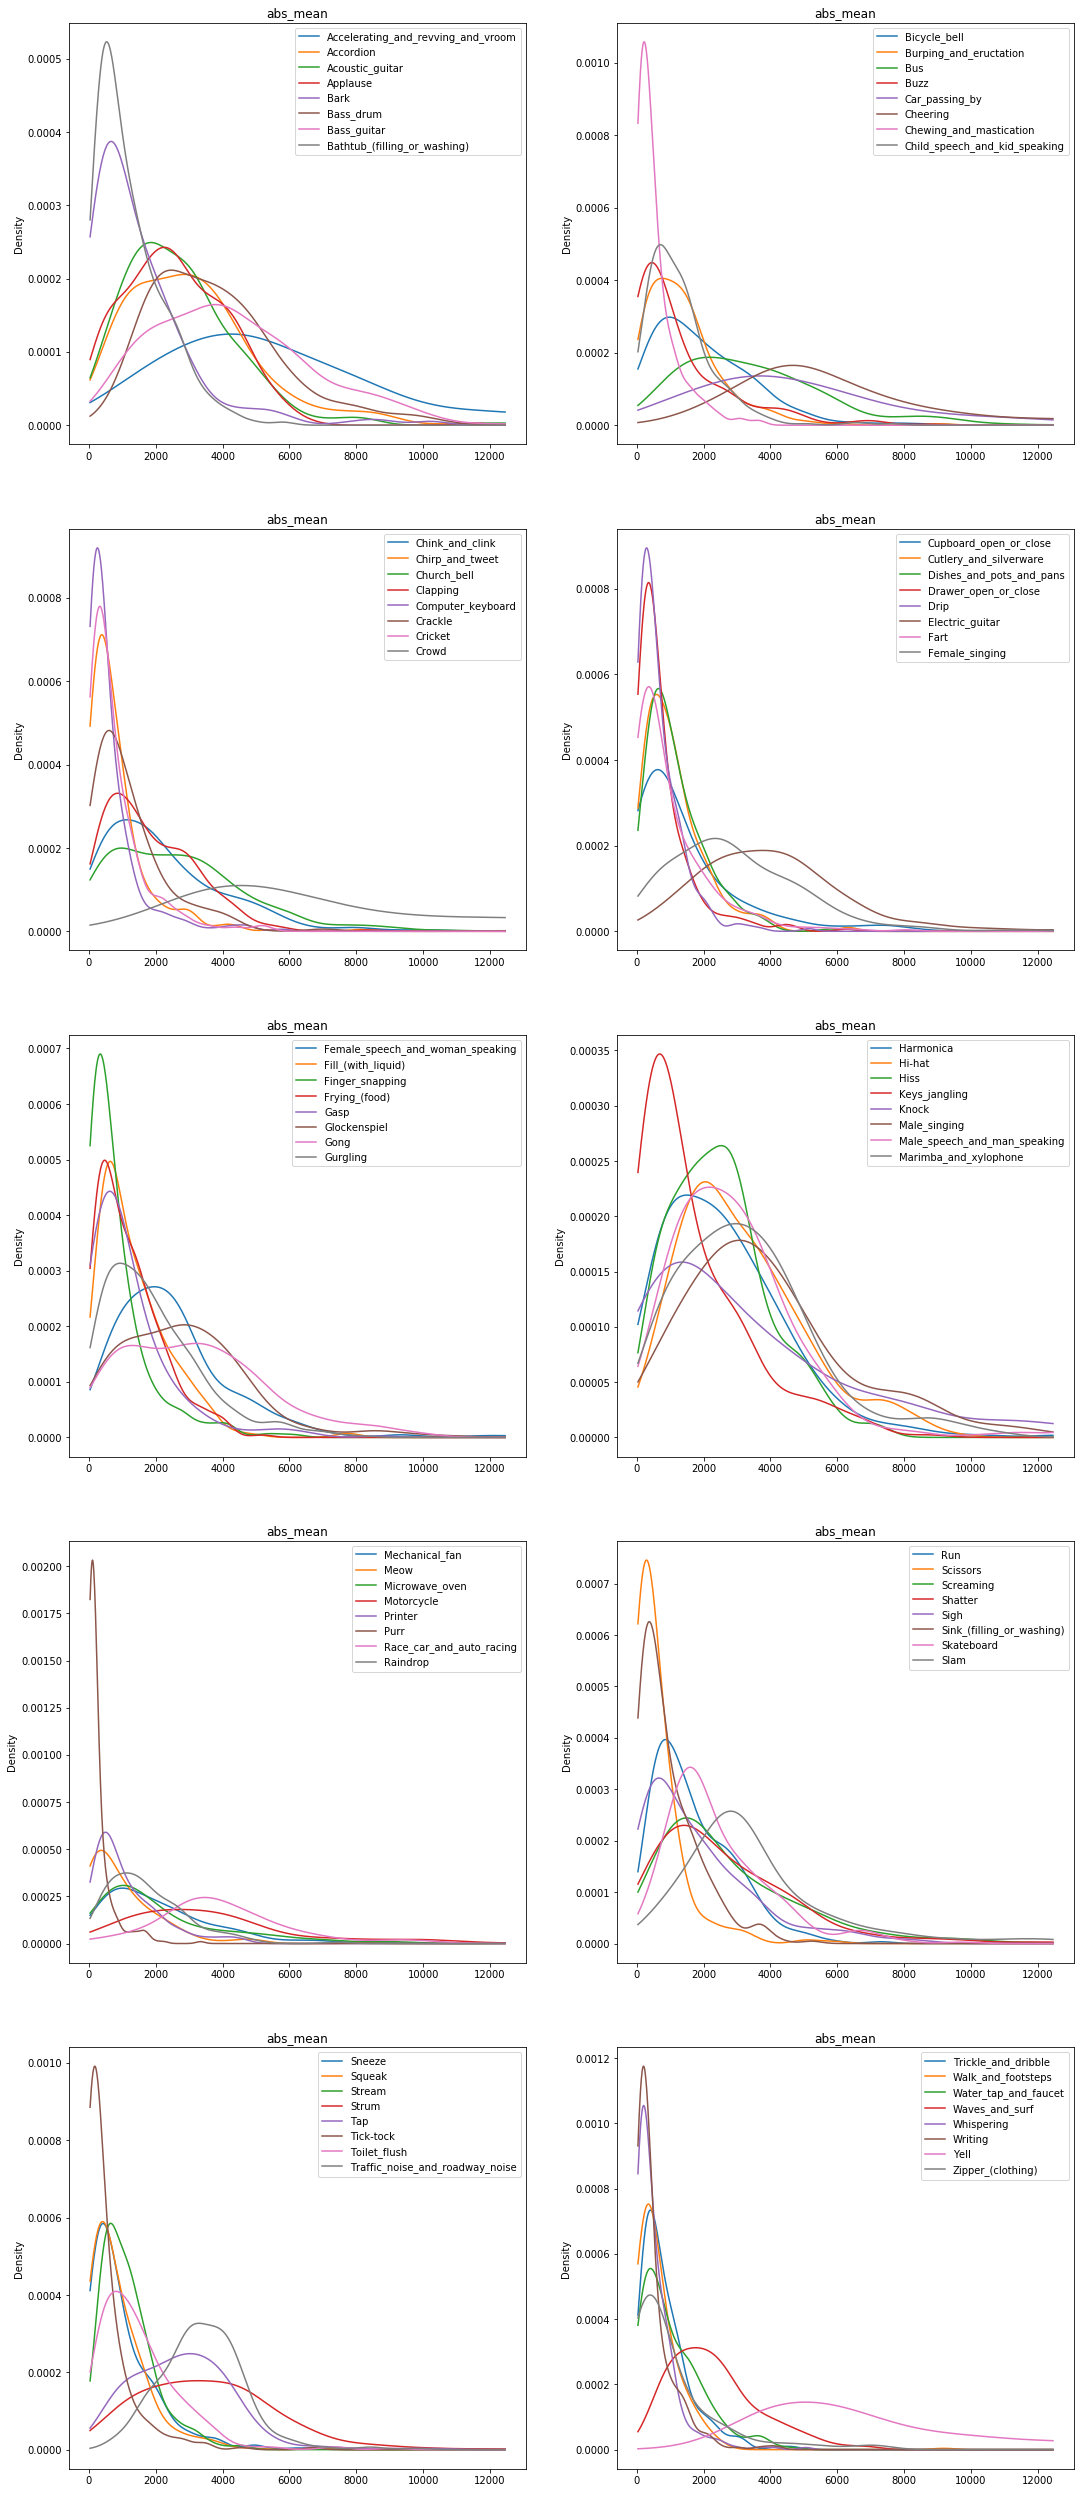

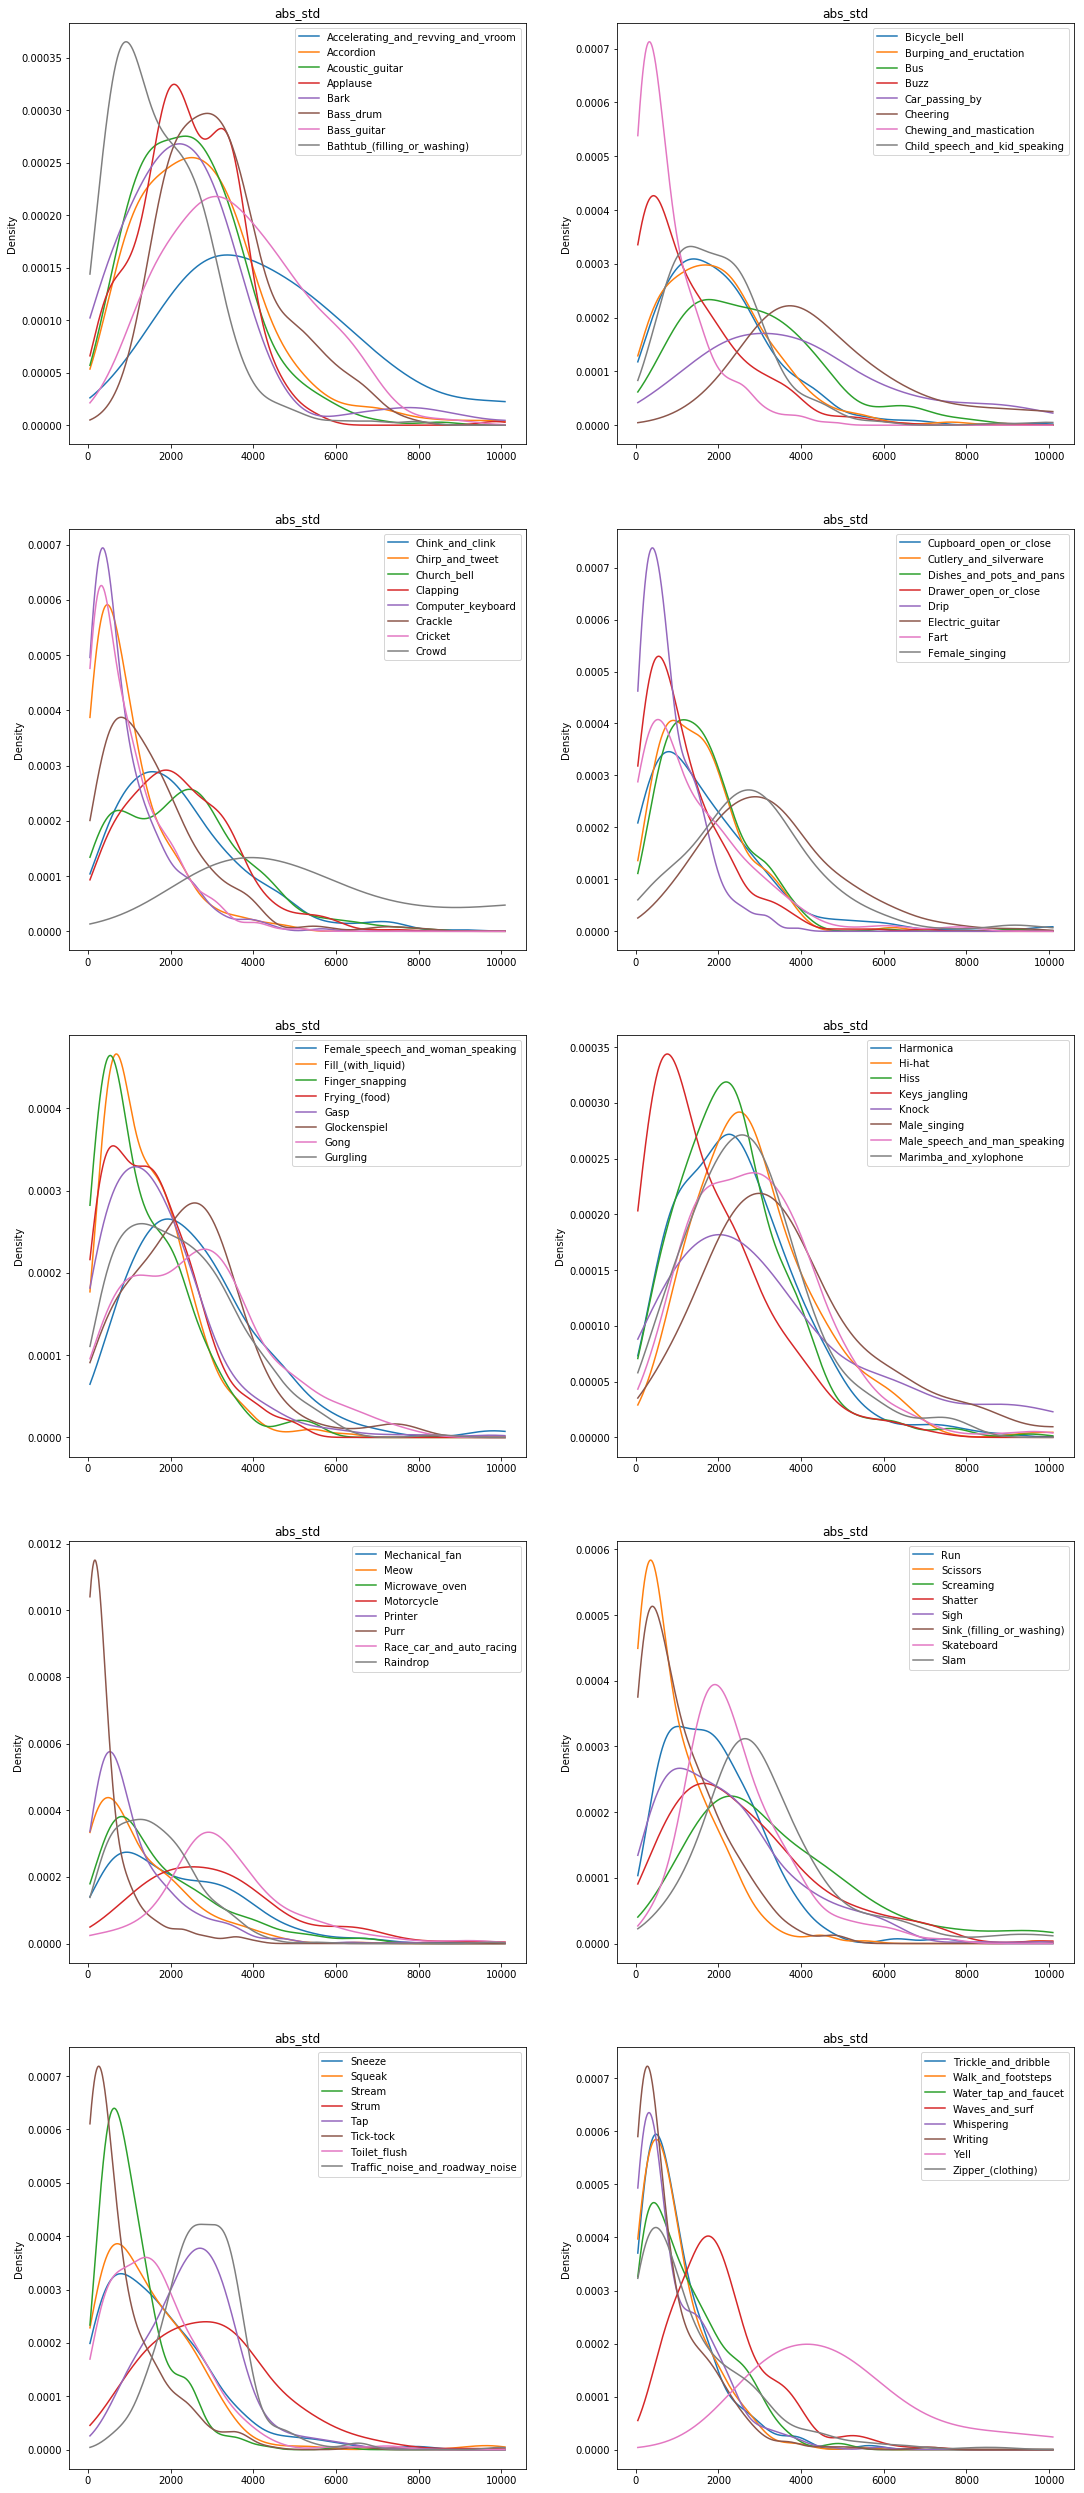

In [15]:
for stat in stats:
    plot_label_stats(train_df[train_df.source=='noisy'], stat)

In [16]:
curated_count  = [train_df[(train_df[c] == 1)&(train_df.source=='curated')].count().values[0] for c in mlb.classes_]

noisy_count    = [train_df[(train_df[c] == 1)&(train_df.source=='noisy')].count().values[0] for c in mlb.classes_]

class_count_df = pd.DataFrame({'class':mlb.classes_, 'curated_count': curated_count, 'noisy_count': noisy_count})

<Figure size 720x360 with 0 Axes>

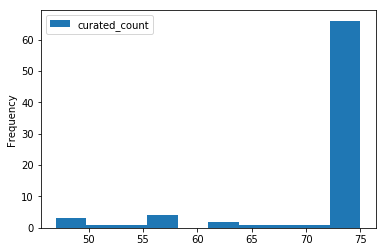

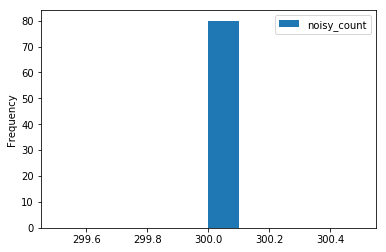

In [17]:
ax = plt.figure(figsize=(10,5))
class_count_df[['curated_count']].plot.hist()
class_count_df[['noisy_count']].plot.hist()

In [18]:
class_count_df[class_count_df.curated_count < class_count_df.curated_count.median()].sort_values(by='curated_count')

class  curated_count  noisy_count
1                  Accordion             47          300
36                      Gasp             48          300
48            Mechanical_fan             49          300
33        Fill_(with_liquid)             50          300
72       Trickle_and_dribble             53          300
11                      Buzz             56          300
37              Glockenspiel             56          300
54  Race_car_and_auto_racing             56          300
60                      Sigh             57          300
35             Frying_(food)             63          300
64                    Sneeze             63          300
53                      Purr             65          300
8               Bicycle_bell             67          300
69                 Tick-tock             72          300

### Listen to some samples

In [19]:
sample = train_df.sample(1)
sample.labels.values[0], sample.source.values[0]

('Male_speech_and_man_speaking', 'noisy')

In [20]:
ipd.Audio(sample.full_path.values[0])